# Application summary analysis

This notebook contains analysis comparing the results of CAIRE to other models.

It has been modified slightly from the original notebook: absolute paths have been anonymized, and some additional explanatory comments have been added.

In particular, CAIRE_PATH is the path to the output of running cross_validate.sh (it is a folder produced by aim, with the format '{random-words}-{random-hash}'). Similarly, ATTENTION_CAIRE_PATH is the output of cross_validate_attention.sh, SIMPLE_CAIRE_PATH is the output of cross_validate_simple.sh and NOSELECT_PATH is the output of cross_validate_noselect.sh.

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
from scipy.special import erf
from scipy.stats import norm, binomtest, false_discovery_control, spearmanr, binom, uniform, pearsonr
from sklearn import metrics as skl_metrics
from Bio import SeqIO
import seaborn as sns


# Set (Bayesian) p-value threshold.
thresh = 0.05
# Save figures.
save = True

In [2]:
model_paths = {'CAIRE': CAIRE_PATH,
          'Attention CAIRE': ATTENTION_CAIRE_PATH,
          'Non-Neural CAIRE': SIMPLE_CAIRE_PATH,
          'Uncorrected': NOSELECT_PATH}

## Predictive performance

In [5]:
outcome_r2, treatment_explain, confound_explain = {}, {}, {}
for model_key in model_paths:
    results_file = os.path.join(model_paths[model_key], 'cv_results.pkl')
    with open(results_file, 'rb') as f:
        cv_results = pickle.load(f)
    outcome_r2[model_key] = np.array([result['outcome_r2_test'] for result in cv_results])
    treatment_explain[model_key] = np.array([result['outcome_treatment_explained_test'] for result in cv_results])
    confound_explain[model_key] = np.array([result['outcome_confound_explained_test'] for result in cv_results])
    

In [6]:
outcome_r2

{'CAIRE': array([ 0.07092637,  0.11498189, -0.13761973,  0.02673382,  0.10155737,
        -0.0268681 ,  0.0344463 ,  0.04920179,  0.03141516,  0.1599276 ,
         0.05608344,  0.05498266,  0.03519082,  0.06447583,  0.02005923,
         0.03360063, -0.0666002 ,  0.10894203,  0.03490609,  0.15471387,
        -0.25368714,  0.00984067,  0.0216307 ,  0.02251178], dtype=float32),
 'Attention CAIRE': array([ 0.05318505,  0.01119435,  0.00069851,  0.0713768 ,  0.05548859,
         0.01003414,  0.02825886,  0.12442648,  0.11010462,  0.09887153,
         0.07046586, -0.05970764,  0.0123648 , -0.01642013, -0.03379071,
         0.03054821,  0.03296089,  0.01065361,  0.06122541,  0.11243373,
        -0.0376327 , -0.01002312,  0.06429338,  0.0554595 ], dtype=float32),
 'Non-Neural CAIRE': array([ 0.04056007,  0.01166469,  0.02766848, -0.03471279,  0.02299452,
         0.06950885,  0.0245207 , -0.01352918,  0.03463018,  0.10513502,
         0.07481283,  0.03297943,  0.02822405, -0.0740968 , -0.06511

In [7]:
df_predictive = pd.DataFrame(
    {f'Outcome $R^2$': [np.median(outcome_r2[model_key]) for model_key in outcome_r2],
     f'Treatment explained': [np.median(treatment_explain[model_key]) for model_key in outcome_r2],
     f'Confounder explained': [np.median(confound_explain[model_key]) for model_key in outcome_r2]},
    index=[model_key for model_key in outcome_r2])

In [8]:
df_predictive

,Outcome $R^2$,Treatment explained,Confounder explained
CAIRE,0.034676,0.012171,0.026096
Attention CAIRE,0.031755,0.032361,0.023738
Non-Neural CAIRE,0.023758,0.003152,0.022136
Uncorrected,0.030585,0.031366,0.000000


In [10]:
def median_CI(x, alpha=0.05):
    """Confidence interval for binomial distribution."""
    # https://stats.stackexchange.com/questions/122001/confidence-intervals-for-median
    n = len(x)
    lower_indx = binom(n, 0.5).ppf(alpha/2)
    lower_limit = np.quantile(x, lower_indx / n)
    upper_limit = np.quantile(x, 1 - lower_indx / n)
    median = np.quantile(x, 0.5)
    return lower_limit, median, upper_limit

In [38]:
# Display LaTeX table.
print(f'& Outcome $R^2$ & Treatment explained & Confounder explained\\\\')
print('\hline')
for model_key in model_paths:
    row = model_key
    lw, med, hi = median_CI(outcome_r2[model_key])
    row += ' & {:.3f} [{:.3f}, {:.3f}]'.format(med, lw, hi)
    lw, med, hi = median_CI(treatment_explain[model_key])
    row += ' & {:.3f} [{:.2f}, {:.3f}]'.format(med, lw, hi)
    lw, med, hi = median_CI(confound_explain[model_key])
    row += ' & {:.3f} [{:.2f}, {:.3f}]'.format(med, lw, hi)
    row += '\\\\'
    print(row)

& Outcome $R^2$ & Treatment explained & Confounder explained\\
\hline
CAIRE & 0.035 [0.022, 0.059] & 0.012 [-0.00, 0.052] & 0.026 [0.01, 0.057]\\
Attention CAIRE & 0.032 [0.010, 0.062] & 0.032 [0.01, 0.040] & 0.024 [0.00, 0.039]\\
Non-Neural CAIRE & 0.024 [0.011, 0.036] & 0.003 [0.00, 0.007] & 0.022 [0.00, 0.038]\\
Uncorrected & 0.031 [0.014, 0.046] & 0.031 [0.02, 0.051] & 0.000 [0.00, 0.000]\\


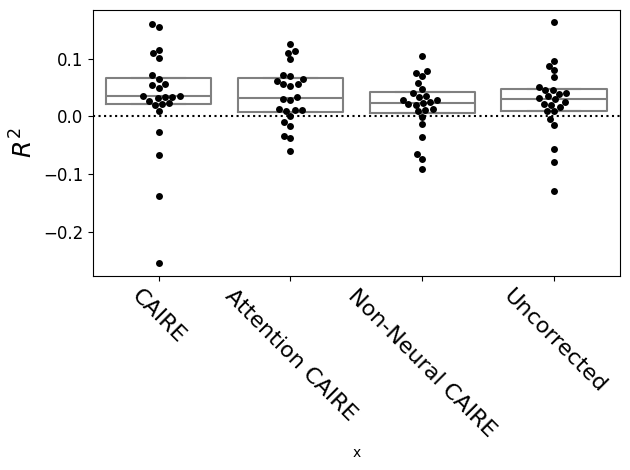

In [116]:
for j, model_key in enumerate(model_paths):
    dat = {'y': outcome_r2[model_key], 
           'x': j * np.ones_like(outcome_r2[model_key])}
    sns.boxplot(dat, x='x', y='y', fill=False, flierprops={"marker": ""}, color='grey', whis=0)
    sns.swarmplot(dat, x='x', y='y', color='black')
plt.xticks(np.arange(len(model_paths)), [model_key for model_key in model_paths],
       rotation=-45, fontsize=16)
plt.ylabel(f'$R^2$', fontsize=18)
plt.yticks(fontsize=12);
xlim = [-0.5, len(model_paths)-1 + 0.5]
plt.xlim(xlim)
plt.plot(xlim, [0, 0], 'k:')
plt.tight_layout()
if save:
    plt.savefig('saved_figs/outcome_r2_distributions.pdf')

/home/enw/miniconda3/envs/cir/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/enw/miniconda3/envs/cir/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/enw/miniconda3/envs/cir/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


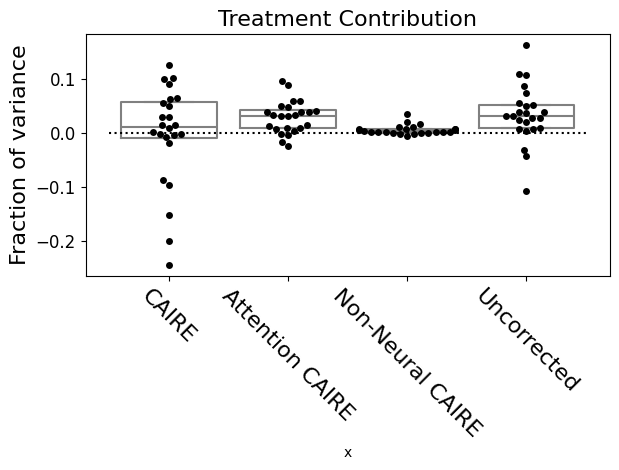

In [119]:
for j, model_key in enumerate(model_paths):
    dat = {'y': treatment_explain[model_key], 
           'x': j * np.ones_like(treatment_explain[model_key])}
    sns.boxplot(dat, x='x', y='y', fill=False, flierprops={"marker": ""}, color='grey', whis=0)
    sns.swarmplot(dat, x='x', y='y', color='black')
plt.xticks(np.arange(len(model_paths)), [model_key for model_key in model_paths],
           rotation=-45, fontsize=16)
plt.ylabel('Treatment var. explained', fontsize=18)
plt.yticks(fontsize=12);
plt.ylabel('Fraction of variance', fontsize=16)
plt.title('Treatment Contribution', fontsize=16)
plt.yticks(fontsize=12);
xlim = [-0.5, len(model_paths)-1 + 0.5]
plt.plot(xlim, [0, 0], 'k:')
plt.tight_layout()
if save:
    plt.savefig('saved_figs/treatment_explain_distributions.pdf')


/home/enw/miniconda3/envs/cir/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 45.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/enw/miniconda3/envs/cir/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/enw/miniconda3/envs/cir/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 37.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


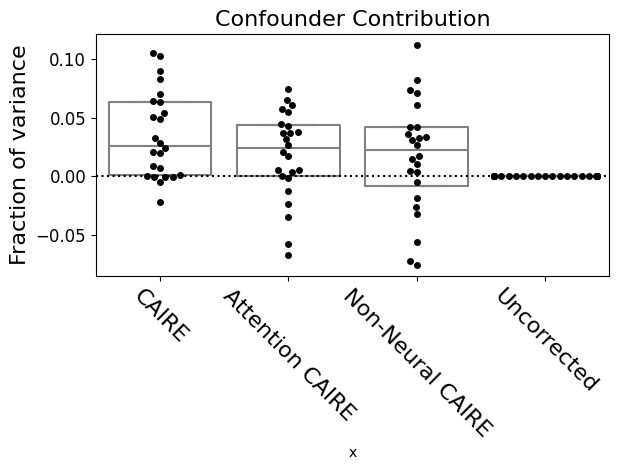

In [120]:
for j, model_key in enumerate(model_paths):
    dat = {'y': confound_explain[model_key], 
           'x': j * np.ones_like(confound_explain[model_key])}
    sns.boxplot(dat, x='x', y='y', fill=False, flierprops={"marker": ""}, color='grey', whis=0)
    sns.swarmplot(dat, x='x', y='y', color='black')
plt.xticks(np.arange(len(model_paths)), [model_key for model_key in model_paths],
           rotation=-45, fontsize=16)
plt.ylabel('Fraction of variance', fontsize=16)
plt.title('Confounder Contribution', fontsize=16)
plt.yticks(fontsize=12);
xlim = [-0.5, len(model_paths)-1 + 0.5]
plt.xlim(xlim)
plt.plot(xlim, [0, 0], 'k:')
plt.tight_layout()
if save:
    plt.savefig('saved_figs/confound_explain_distributions.pdf')

## Robustness of effect estimates across models

In [7]:
bind_effects_mn = {}
for model_key in model_paths:
    results_file = os.path.join(model_paths[model_key], 'cv_results.pkl')
    with open(results_file, 'rb') as f:
        _ = pickle.load(f)
        _ = pickle.load(f)
        bind_effects = pickle.load(f)
        hits = pickle.load(f)
    bind_effects_mn[model_key] = np.mean(bind_effects, axis=1)

Attention CAIRE PearsonRResult(statistic=0.949678425450786, pvalue=0.0)
Non-Neural CAIRE PearsonRResult(statistic=0.6893733887098724, pvalue=0.0)
Uncorrected PearsonRResult(statistic=0.9442158291386402, pvalue=0.0)


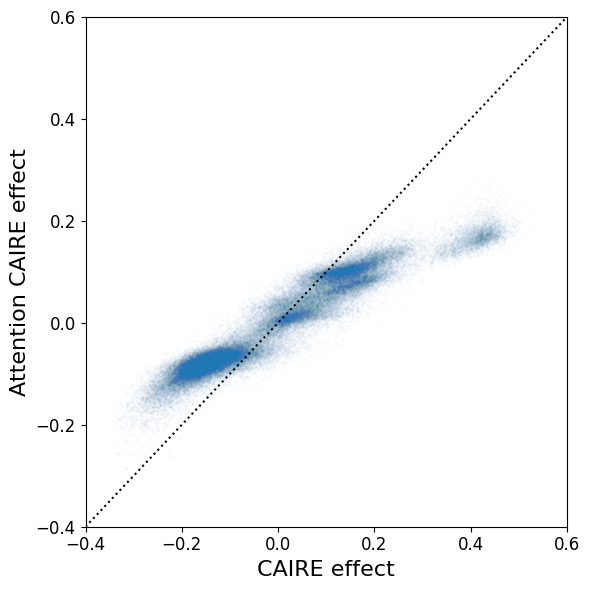

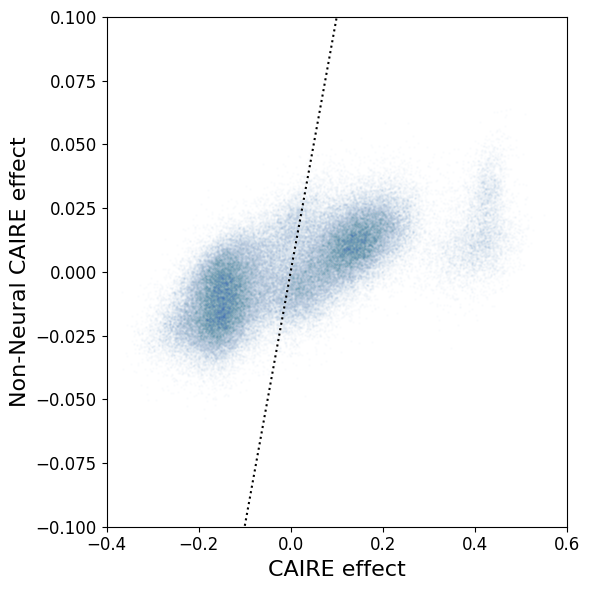

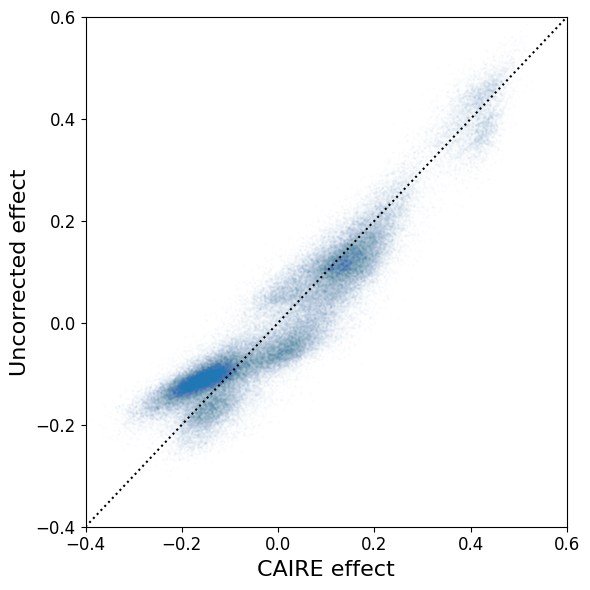

In [12]:
ylims = {'Attention CAIRE': [-0.4, 0.6], 
         'Non-Neural CAIRE': [-0.1, 0.1], 
         'Uncorrected': [-0.4, 0.6]}
save_names = {'Attention CAIRE': 'attention', 
              'Non-Neural CAIRE': 'nonneural', 
              'Uncorrected': 'uncorrected'}
for model_key in ['Attention CAIRE', 'Non-Neural CAIRE', 'Uncorrected']:
    print(model_key, pearsonr(bind_effects_mn['CAIRE'][hits < 0.5], 
                              bind_effects_mn[model_key][hits < 0.5]))
    plt.figure(figsize=(6, 6))
    subset = np.random.choice(sum(hits < 0.5), size=100000, replace=False)
    plt.scatter(bind_effects_mn['CAIRE'][hits < 0.5][subset], 
                bind_effects_mn[model_key][hits < 0.5][subset], s=1, alpha=0.01);
    plt.xlabel('CAIRE effect', fontsize=16)
    plt.ylabel(model_key + ' effect', fontsize=16)
    plt.plot([-.4, .6], [-0.4, 0.6], 'k:')
    plt.ylim(ylims[model_key])
    plt.xlim([-.4, .6])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    if save:
        plt.savefig('saved_figs/effect_correlation_{}.pdf'.format(save_names[model_key]))

## Binding data comparison

Below, BASE_PATH is to the folder containing the individual model runs.

In [3]:
bind_effects_mn = {}
logp_all = {}
for model_key in model_paths:
    results_file = os.path.join(model_paths[model_key], 'cv_results.pkl')
    with open(results_file, 'rb') as f:
        _ = pickle.load(f)
        local_dirs = pickle.load(f)
        bind_effects = pickle.load(f)
        hits = pickle.load(f)
    bind_effects_mn[model_key] = np.mean(bind_effects, axis=1)
    bind_effects_sd = np.std(bind_effects, axis=1)
    logp_all[model_key] = norm(loc=np.abs(bind_effects_mn[model_key]), 
                               scale=bind_effects_sd).logcdf(0)
est_effect_df = pd.read_csv(os.path.join(BASE_PATH, local_dirs[0], 'est_effect.csv'))
patients = est_effect_df['patient']
mhc_class_1_eval = est_effect_df['mhc_class_1_eval']
mhc_class_2_eval = est_effect_df['mhc_class_2_eval']

In [9]:
def AUC_se(h, x):
    auc = skl_metrics.roc_auc_score(h, x)
    auc_sign = np.sign(auc - 0.5)
    auc_sign_str = ['', '+', '-'][int(auc_sign)]
    auc_abs = skl_metrics.roc_auc_score(h, x * auc_sign)
    n = np.sum(h > 0.5)
    m = np.sum(h < 0.5)
    auc_se = 1/(2 * np.sqrt(np.minimum(n, m)))

    return auc_abs, auc_se, auc_sign_str

def weighted_mean_std(val, wgt):
    w_mn = np.sum(val * wgt)
    w_std = np.sqrt(np.sum(wgt * ((val - w_mn) ** 2)) / (1 - np.sum(wgt ** 2)))
    n_eff = 1 / np.sum(wgt ** 2)
    w_se = w_std/np.sqrt(n_eff) 
    return w_mn, w_std, w_se

In [15]:
print('& Class I (all) & sign & Class I (signif.) & sign & Class II (all) & sign & Class II (signif.) & sign & Patients (all) & sign\\\\')
print('\hline')
mhc_classes = {'Class I': mhc_class_1_eval, 'Class II': mhc_class_2_eval}
num_patients = np.max(patients)+1
patient_auc_sign = -1
patient_auc_sign_str = '-'
for model_key in model_paths:
    row = model_key
    for mhc_class in mhc_classes:
        mcind = mhc_classes[mhc_class]
        hits_sub = hits[mcind]
        bem_sub = bind_effects_mn[model_key][mcind]
        lpa_sub = logp_all[model_key][mcind]
        
        auc_abs, auc_se, auc_sign_str = AUC_se(hits_sub, bem_sub)
        row += ' & {:.3f}$\pm${:.3f} ({})'.format(auc_abs, auc_se, auc_sign_str)

        signif = lpa_sub < np.log(thresh)
        if np.sum(signif) == 0:
            row += ' & NA'
        else:
            auc_abs, auc_se, auc_sign_str = AUC_se(hits_sub[signif], bem_sub[signif])
            row += ' & {:.3f}$\pm${:.3f} ({})'.format(auc_abs, auc_se, auc_sign_str)

    patient_aucs = np.zeros(num_patients)
    patient_weights = np.zeros(num_patients)
    for p_i in range(num_patients):
        p_ind = patients == p_i
        hit_sub = hits[p_ind]
        effect_sub = bind_effects_mn[model_key][p_ind]
        patient_weights[p_i] = np.sum(hit_sub)
        # AUC.
        patient_aucs[p_i] = skl_metrics.roc_auc_score(hit_sub, patient_auc_sign*effect_sub)
    patient_weights = patient_weights / np.sum(patient_weights)

    patient_auc, _, patient_auc_se = weighted_mean_std(patient_aucs, patient_weights)

    row += ' & {:.3f}$\pm${:.3f} ({})'.format(patient_auc, patient_auc_se, patient_auc_sign_str)
    
    print(row + '\\\\')
        

& Class I (all) & sign & Class I (signif.) & sign & Class II (all) & sign & Class II (signif.) & sign & Patients (all) & sign\\
\hline
CAIRE & 0.563$\pm$0.003 (-) & 0.604$\pm$0.027 (-) & 0.505$\pm$0.008 (-) & 0.564$\pm$0.058 (+) & 0.553$\pm$0.009 (-)\\
Attention CAIRE & 0.568$\pm$0.003 (-) & 0.526$\pm$0.109 (+) & 0.507$\pm$0.008 (-) & 0.651$\pm$0.500 (+) & 0.557$\pm$0.008 (-)\\
Non-Neural CAIRE & 0.566$\pm$0.003 (-) & NA & NA & 0.502$\pm$0.008 (+) & NA & NA & 0.556$\pm$0.008 (-)\\
Uncorrected & 0.556$\pm$0.003 (-) & 0.534$\pm$0.020 (-) & 0.513$\pm$0.008 (-) & 0.557$\pm$0.052 (-) & 0.549$\pm$0.007 (-)\\


In [16]:
# Simplified header
print('& Class I (all) & Class I (signif.) & Class II (all) & Class II (signif.) & Patients (all) \\\\')

& Class I (all) & Class I (signif.) & Class II (all) & Class II (signif.) & Patients (all) \\
